# Chapter 4 - Implementing a GPT model from scratch to generate text data

In [31]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding Dimension
    "n_heads": 12,          # Number of Attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout Rate
    "qkv_bias": False       # Query-Key-Value Bias

}

In [32]:
import torch
import torch.nn as nn

Place holder classes

In [33]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

In [34]:
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [35]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
             for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [36]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(f"before stach: {batch}")
batch = torch.stack(batch, dim=0)
print(f"after stack: {batch}")
print(f"after batch: {batch.shape}")

before stach: [tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
after stack: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
after batch: torch.Size([2, 4])


In [37]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


Layer Normalization example

In [52]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[2.2595e-01, 3.4695e-01, 0.0000e+00, 2.2160e-01, 0.0000e+00, 0.0000e+00],
        [2.1328e-01, 2.3942e-01, 0.0000e+00, 5.1984e-01, 3.2975e-01, 0.0000e+00]],
       grad_fn=<ReluBackward0>)


examining the mean and varience

In [53]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean: {mean}")
print(f"varience: {var}")

Mean: tensor([[1.3242e-01],
        [2.1705e-01]], grad_fn=<MeanBackward1>)
varience: tensor([[2.3066e-02],
        [3.9823e-02]], grad_fn=<VarBackward0>)


applying layer normalization manually

In [54]:
out_norm = (out - mean)/torch.sqrt(var)
print(f"normalized layer: {out_norm}")

normalized layer: tensor([[6.1585e-01, 1.4126e+00, -8.7188e-01, 5.8723e-01, -8.7188e-01, -8.7188e-01],
        [-1.8865e-02, 1.1211e-01, -1.0876e+00, 1.5173e+00, 5.6474e-01, -1.0876e+00]],
       grad_fn=<DivBackward0>)


In [55]:
mean = out_norm.mean(dim=-1, keepdim=True)
print(f"mean: {mean}")

mean: tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)


In [56]:
var = out_norm.var(dim=-1, keepdim=True)
print(f"var: {var}")

var: tensor([[1.0000e+00],
        [1.0000e+00]], grad_fn=<VarBackward0>)


Encapsulating Layer Normalization to PyTorch module

In [57]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [59]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
torch.set_printoptions(sci_mode=False)
print(f"Mean: {mean}")
print(f"var: {var}")

Mean: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
var: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [70]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2/torch.pi)) * 
            (x + 0.044715 + torch.pow(x,3))
            ))

Plot GELU function

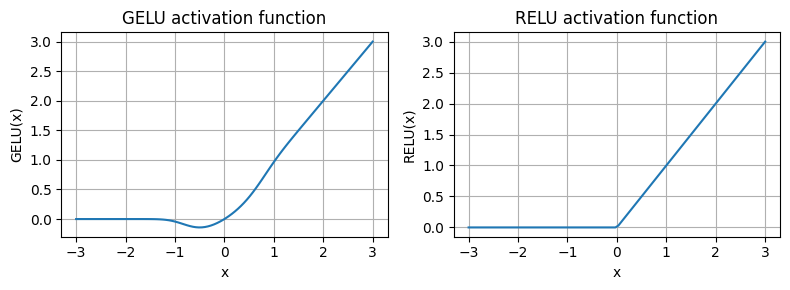

In [71]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

# create 100 sample data points in range -3, 3
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu, y_relu],["GELU", "RELU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [76]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


Example Feed Forward with shortcut connection

In [98]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [99]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [100]:
def print_gradients(model, x):
    output = model(x)
    print(f"output:{output}")
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [101]:
print_gradients(model_without_shortcut, sample_input)

output:tensor([[0.0622]], grad_fn=<MulBackward0>)
layers.0.0.weight has gradient mean of 0.0002475684741511941
layers.1.0.weight has gradient mean of 0.00015160041220951825
layers.2.0.weight has gradient mean of 0.0008637128048576415
layers.3.0.weight has gradient mean of 0.001529233530163765
layers.4.0.weight has gradient mean of 0.005495645105838776


from the above example we see a vanishing gradientfrom layer 4 to layer 1

We will now instantiate a model with skip connections

In [102]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

output:tensor([[0.9603]], grad_fn=<MulBackward0>)
layers.0.0.weight has gradient mean of 0.3107847571372986
layers.1.0.weight has gradient mean of 0.2917015850543976
layers.2.0.weight has gradient mean of 0.48102134466171265
layers.3.0.weight has gradient mean of 0.39286816120147705
layers.4.0.weight has gradient mean of 1.8537139892578125


import MultiHeadAttention from chapter 3

In [110]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout,
                 num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
        "d_out must be a divisible my num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_ptoj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # The tensor shapes will be now (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        """
        We implicitely split matrix by adding a num_heads dimension.
        Then we unroll the last dim: 
        (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        """
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        """
        Transposes from shape (b, num_tokens, num_heads, head_dim) 
        to (b, num_heads, num_tokens, head_dim) 
        """
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        #Compute dot product for each head
        attn_scores = queries @ keys.transpose(2,3)
        #masks truncated to number of token
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # print(f"mask_bool: {mask_bool}")
        #use the mask to fill the attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        #Tensor shape: (b, num_tokens, num_heads, head_dim)
        context_vecs = (attn_weights @ values).transpose(1,2)

        #Combines heads, Where self.d_out = self.num_heads * self.head_dim
        context_vecs = context_vecs.contiguous().view(
            b, num_tokens, self.d_out
        )

        #Adds an optional linear projection
        context_vecs = self.out_ptoj(context_vecs)

        return context_vecs



In [111]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        #Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        # Add original input back
        x = x + shortcut

        #Shortcut for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x+shortcut
        return x

Feed sample data to transformer block

In [112]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input Shape:", x.shape)
print("Output shape:", output.shape)

Input Shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


update the GPT model with transformerblock and layer normalization

In [113]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb =nn.Dropout(cfg["drop_rate"])

        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [115]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(f"Input batch:\n {batch}")
print(f"Output: \n {out}")
print(f"Output Shape: {out.shape}")

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output: 
 tensor([[[ 0.3353,  0.4403, -0.0822,  ...,  0.3335,  0.4584, -0.3086],
         [-0.2477, -0.5299, -1.0065,  ...,  0.0173,  0.5226, -0.3643],
         [ 0.6933,  0.0323,  0.1004,  ...,  0.0297, -0.3547, -0.2467],
         [-1.0391,  0.3932, -0.1123,  ...,  0.7301,  0.3848,  0.0335]],

        [[-0.3025,  0.1131,  0.0043,  ...,  0.2131,  0.4553, -0.7163],
         [ 0.0976,  0.3940, -0.2042,  ...,  0.7415,  0.2714,  0.1652],
         [ 1.0650,  1.0320, -0.2525,  ...,  0.6274,  0.3092, -0.3420],
         [-0.2596,  0.4945,  0.3291,  ...,  1.2046, -0.2345,  0.0429]]],
       grad_fn=<UnsafeViewBackward0>)
Output Shape: torch.Size([2, 4, 50257])


Calculate total number of parameters

In [116]:
total_params =sum(p.numel() for p in model.parameters())
print(f"Total number of parameters:{total_params}")

Total number of parameters:163009536


we were supposed to 124 million parameter but now we have 163 million

This is because of the concept called as weight tying

This means that the GPT-2 reuses the weights from the token embedding layer in its output layer

In [117]:
print(f"Token Embedding layer shape: {model.tok_emb.weight.shape}")
print(f"Output layer shape: {model.out_head.weight.shape}")

Token Embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


if we remove the output layer parameters count from the total GPT-2 model count according to weight tying

In [118]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters, cosidering weight tying: {total_params_gpt2}")

Number of trainable parameters, cosidering weight tying: 124412160


displaying total transformers parameters

In [123]:
total_trf_params = sum(p.numel() for p in model.trf_block.parameters())
total_trf_params

85026816

displaying total feedforward parameters

In [125]:
total_ff_parameters = sum(p.numel() for block in model.trf_block for p in block.ff.parameters())
total_ff_parameters

56669184

displaying total attention parameters

In [127]:
total_attn_parameters = sum(p.numel() for block in model.trf_block for p in block.att.parameters())
total_attn_parameters

28320768

Memory requirements for 163 million parameters (assuming 1 float32 parameter requires 4 bytes)

In [129]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb} MB")

Total size of the model: 621.83203125 MB


generate text from last vector from the GPT output

In [139]:
# idx is a (batch_size, n_tokens) array of indices in the current context
def generate_text_sample(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        """
        crops current context if it exceeds the supported context size
        eg: if LLM supports only 5 tokens and the context size is 10
        only 5 tokens are used as context
        """
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        """
        Focuses only on the last time step so that (batch_size, n_tokens, vocab_size)
        becomes (batch_size, vocab_size)
        """
        logits = logits[:,-1,:]
        # probas has shape (batch_size, vocab_size)
        probas = torch.softmax(logits, dim=-1)
        # idx_next has shape (batch_size, 1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        """
        Append sampled index tot he running sequence
        where idx has shape (batch, n_tokens+1)
        """
        idx = torch.cat((idx, idx_next), dim=-1)
    return idx

generate text sample

In [140]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"encoded_tensor: {encoded_tensor}")
print(f"encoded tensor shape: {encoded_tensor.shape}")

encoded: [15496, 11, 314, 716]
encoded_tensor: tensor([[15496,    11,   314,   716]])
encoded tensor shape: torch.Size([1, 4])


In [141]:
model.eval()
out = generate_text_sample(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print(f"Output: {out}")
print(f"Output length: {len(out[0])}")

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 29739,   554]])
Output length: 10


decode token id into text

In [142]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswick Exit In
